In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import userdata

In [69]:
p1 = pd.read_csv(userdata.get('TEMP_1'))
p1

,Unnamed: 0,Response
0,0,A. 2
1,1,C. 2
2,2,C. 2
3,3,B. 3
4,4,B. 3
...,...,...
87,87,C. 2
88,88,A. 2
89,89,B. 2
90,90,B. 2


In [70]:
experiments = pd.read_csv(userdata.get('EXPERIMENTS_FILE'))
experiments

,ID,USER ID,Trial ID,Target,Response,Correct,A,B,C,D
0,0,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,0,A,D,0,319,125,205,81
1,1,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,1,A,B,0,205,210,250,119
2,2,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,2,C,C,1,77,119,156,55
3,3,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,3,A,A,1,302,316,55,97
4,4,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,4,B,A,0,53,72,201,99
...,...,...,...,...,...,...,...,...,...,...
5214,5214,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,66,C,C,1,27251,27113,27194,27144
5215,5215,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,67,B,B,1,27171,27146,27100,27225
5216,5216,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,68,A,A,1,27251,27065,27117,27227
5217,5217,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,69,B,A,0,27095,27113,27144,27065


In [71]:
# Get participants response
uuids = experiments['USER ID'].unique()
uuid = uuids[0] #test with 1st participant

experiments_temp = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
target = experiments_temp['Target']
response = experiments_temp['Response']
experiments_offset = experiments_temp.index.min()

In [ ]:
# Generate & Clean Model's list of response
response = p1['Response']
model_response_alpha = []

for res in response:
  model_response_alpha.append(res[0])

model_response_alpha

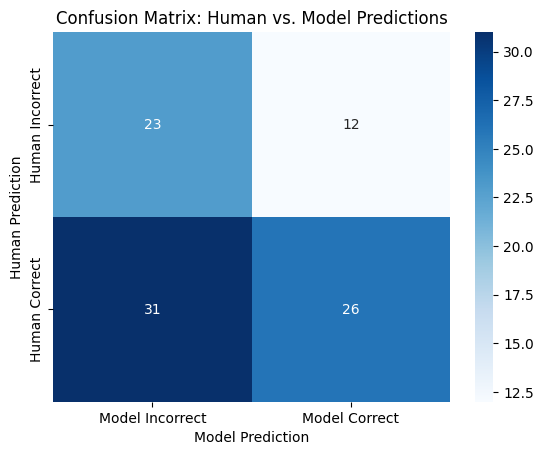

In [72]:
# Plot CM

# Transform to binary: 1 for correct prediction, 0 for incorrect
binary_human = (response == target).astype(int)
binary_model = (model_response_alpha == target).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(binary_human, binary_model)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Model Incorrect', 'Model Correct'],
            yticklabels=['Human Incorrect', 'Human Correct'])

plt.ylabel('Human Prediction')
plt.xlabel('Model Prediction')
plt.title('Confusion Matrix: Human vs. Model Predictions')
plt.show()

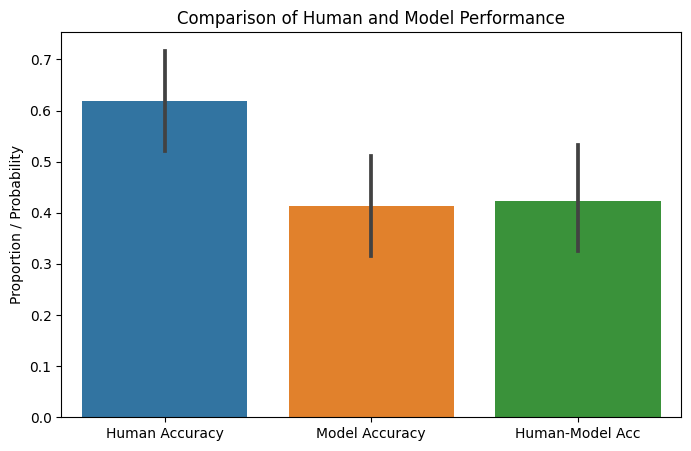

In [73]:
# Plot bar chart

# Calculate accuracies and agreement
human_accuracy = np.mean(response == target)
model_accuracy = np.mean(model_response_alpha == target)
equivalence = np.mean(response == model_response_alpha)

series = {"Human Accuracy": pd.Series((response == target).astype(int)),
          "Model Accuracy": pd.Series((model_response_alpha == target).astype(int)),
          "Human-Model Acc": pd.Series((model_response_alpha == response).astype(int))}
df = pd.DataFrame(series)

# Data for plotting
categories = ['Human Accuracy', 'Model Accuracy', 'Equivalence']
# values = [human_accuracy, model_accuracy, equivalence]

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=df, errorbar=("ci", 95))
# sns.barplot(x=categories, y=values, errorbar=("ci", 95))#, capsize=.2)
plt.title('Comparison of Human and Model Performance')
plt.ylabel('Proportion / Probability')
plt.show()

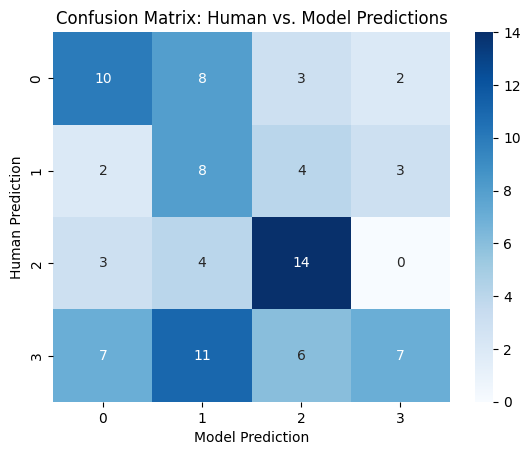

In [74]:
# Plot (new) CM

# Calculate the confusion matrix
cm = confusion_matrix(response, model_response_alpha)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.ylabel('Human Prediction')
plt.xlabel('Model Prediction')
plt.title('Confusion Matrix: Human vs. Model Predictions')
plt.show()